In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

RAND_INIT = 1234

In [2]:
def get_alg(name, k, random_state, max_iter):
    if name == 'km':
        return KMeans(n_clusters=k, random_state=random_state, max_iter=max_iter)
    elif name == 'gm':
        return GaussianMixture(n_components=k, random_state=random_state, max_iter=max_iter)
    elif name == 'db':
        return DBSCAN(eps=2.4)
    else:
        raise Exception('unknown alg')

In [3]:
def norm_X(df):
    real_X = df.iloc[:, 4:].as_matrix().astype(float)
    
    for i in xrange(real_X.shape[1]):
        col = real_X[:,i]
        col_std = np.std(col)
        col_mean = np.mean(col)
        real_X[:,i] = (col - col_mean) / col_std
        
    return real_X

def tfidf_X(df):
    real_X = df.iloc[:, 4:].as_matrix()
    trf = TfidfTransformer()
    real_X = trf.fit_transform(real_X).toarray()

    return real_X

def norm_tfidf_X(df):
    real_X = df.iloc[:, 4:].as_matrix()
    trf = TfidfTransformer()
    real_X = trf.fit_transform(real_X).toarray()

    for i in xrange(real_X.shape[1]):
        col = real_X[:,i]
        col_std = np.std(col)
        col_mean = np.mean(col)
        real_X[:,i] = (col - col_mean) / col_std

    return real_X

In [4]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
X = norm_X(df_sns)

In [5]:
X = np.concatenate((X[:14187], X[14188:]))
df_sns = df_sns.drop(df_sns.index[14187])

In [35]:
kmeans = get_alg('km', k=8,random_state=RAND_INIT, max_iter=300)
# kmeans = KMeans(n_clusters=9, random_state=RAND_INIT, max_iter=300)
%time kmeans.fit(X)
y = kmeans.predict(X)

CPU times: user 5.98 s, sys: 42 ms, total: 6.02 s
Wall time: 7.94 s


In [29]:
gm = get_alg('gm', k=8,random_state=RAND_INIT, max_iter=300)
%time gm.fit(X)
y = gm.predict(X)

CPU times: user 22.7 s, sys: 236 ms, total: 23 s
Wall time: 22 s


In [19]:
db = DBSCAN(eps=2.4)
%time db.fit(X[:10000])
y = db.labels_

CPU times: user 15 s, sys: 86 ms, total: 15.1 s
Wall time: 15.2 s


In [12]:
represent = df_sns.iloc[:, :4]
represent['cluster'] = y
represent.groupby('cluster').agg({'cluster':{'size': len}})

,cluster
,size
cluster,
0,3389
1,946
2,15760
3,364
4,2360
5,860
6,806
7,4556


In [39]:
df_clusters = df_sns.copy()
df_clusters['cluster'] = y
interests = df_clusters.columns[4:-1]
aggs = {key : np.sum for key in interests}
aggs['cluster'] = {'size': len}

res = df_clusters.groupby('cluster').agg(aggs)
res.columns = res.columns.get_level_values(0)

# res

for interest in interests:
#     res[interest] = res[interest] / res['cluster'] * 100000
#     col_std = np.std(res[interest])
#     col_mean = np.mean(res[interest])
#     res[interest] = (res[interest] - col_mean) / col_std

    res[interest] = res[interest] / np.sum(res[interest]) / res['cluster'] * 100000
#     res[interest] = res[interest] / np.sum(res[interest])
    
from IPython import display
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display.display(res)

,cute,drunk,dance,sex,hair,cluster,church,blonde,kissed,dress,marching,basketball,god,tennis,sports,hot,music,abercrombie,soccer,shopping,drugs,football,cheerleading,band,death,baseball,softball,sexy,jesus,bible,die,volleyball,mall,rock,hollister,clothes,swimming
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.593421,1.912316,1.700420,1.557227,1.475450,20496,1.729440,1.609091,1.076343,1.135061,0.709017,1.863389,2.237506,2.456260,2.092660,1.433640,2.466943,0.600737,1.252055,1.554922,1.135653,2.009759,1.401626,1.833358,2.270497,1.055464,1.633396,1.993075,2.007634,0.289691,2.213547,1.662314,1.493211,2.153739,0.693675,1.175386,1.930540
1,6.439661,3.962690,5.469171,3.895292,7.321874,853,3.149316,8.611609,4.543926,5.285541,0.770005,4.838431,3.370174,6.040647,4.467094,8.364988,4.173473,76.144361,3.701365,8.834010,4.138406,5.468925,9.528183,2.100207,4.626277,3.314410,4.508973,4.733623,3.209004,1.282239,3.909901,6.197475,8.821726,3.999327,72.096239,9.528166,6.456411
2,7.225534,32.317952,7.353679,40.762937,25.085027,966,5.144698,17.089957,54.635381,10.610222,2.634737,6.815260,6.664325,5.768653,12.154131,7.004885,9.765036,8.092743,3.733090,4.985366,57.212746,6.812845,6.310202,8.132290,15.402371,5.656094,5.715416,9.777537,4.404437,4.690735,23.116953,4.990352,8.714905,14.835124,6.321812,16.176401,6.677031
3,3.016364,4.480726,3.259607,3.170956,3.666952,534,25.983303,4.041710,2.600916,3.433490,2.767477,4.506524,30.166070,4.360008,3.300233,2.958387,4.737697,1.585965,2.577954,3.377506,4.441497,3.811147,3.336717,4.605070,7.061474,2.914876,4.027224,1.945620,52.764303,153.616573,6.007988,3.488885,2.498172,4.233303,1.608200,3.868088,4.273993
4,8.714779,3.722919,8.610731,3.384237,5.823413,5315,6.600931,5.072340,2.868387,10.258437,0.818701,6.878383,4.213710,5.256619,4.955711,9.154692,4.842431,2.071453,2.153707,8.964953,2.106663,5.736151,9.092682,2.847219,4.674795,2.456427,8.835428,7.214884,3.353166,0.470367,3.751340,8.798293,8.643395,4.704313,2.648058,8.393525,7.206613
5,3.129398,1.885968,3.718951,2.598582,3.014997,584,3.840952,2.852801,2.654773,3.963009,128.354365,2.498036,3.989582,4.248144,2.324428,2.614931,6.219617,0.780867,1.511707,3.055998,2.077840,4.027944,1.445229,54.473661,3.854116,1.468643,3.045084,2.789863,3.464396,1.872860,3.414105,2.312880,2.550418,4.973472,0.571866,3.306248,3.823111
6,4.994276,2.132906,2.784009,4.890726,4.090927,552,4.963938,15.571067,2.633131,1.687990,1.189881,12.423651,3.129932,4.563558,12.295888,3.672795,3.846620,1.534249,5.014887,2.309398,2.597984,16.183926,7.475162,2.580217,2.965486,95.125960,6.593064,4.662663,3.126226,1.981431,2.791109,5.062676,3.871429,9.282590,1.296465,2.806466,4.359331
7,3.367891,2.499366,3.095890,2.125355,3.366153,699,4.227473,5.416945,2.356634,3.397012,1.174561,5.458457,3.240909,5.241949,7.597694,4.181103,3.464241,2.516391,73.104157,4.674153,2.446170,5.369297,2.817404,2.785776,3.052760,2.999384,3.756992,2.972707,3.022127,2.458870,3.267310,4.364476,3.650190,4.037632,3.139709,2.858661,4.649233


In [40]:
for i, row in enumerate(res.as_matrix().argsort(axis=1)):
    top_inds = row[::-1][0:6]
    print('{} : {}'.format(i, ' '.join(res.columns[top_inds])))

0 : cluster music tennis death god die
1 : cluster abercrombie hollister cheerleading clothes shopping
2 : cluster drugs kissed sex drunk hair
3 : cluster bible jesus god church death
4 : cluster dress hot cheerleading shopping softball
5 : cluster marching band music rock tennis
6 : cluster baseball football blonde basketball sports
7 : cluster soccer sports basketball blonde football


In [21]:
def k_plot(X, alg_name, quality, k_start, k_end, random_state, max_iter):
    ks = xrange(k_start, k_end + 1)
    criteria = np.empty(len(ks))

    for i, k in enumerate(ks):
        x = X[:]
        cls = get_alg(alg_name, k=k, random_state=random_state, max_iter=max_iter)
        yl = cls.fit(x).predict(x)
        x, yl = shuffle(x, yl, random_state=RAND_INIT)
        criteria[i] = quality(x[:10000], yl[:10000])

    plt.figure(figsize=(8, 6))
    plt.plot(ks, criteria)
    plt.title("$J(k)$")
    plt.ylabel("Criteria $J$")
    plt.xlabel("Number of clusters $k$")
    plt.grid()
    plt.show()

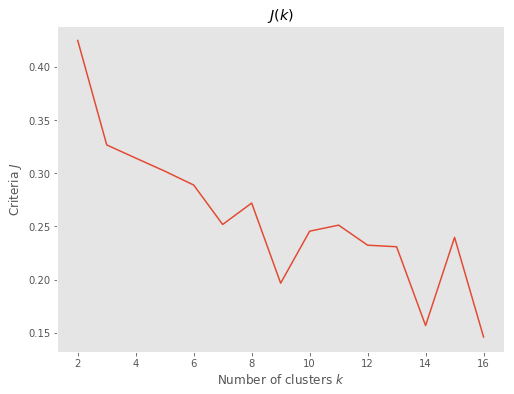

CPU times: user 3min 19s, sys: 14.6 s, total: 3min 34s
Wall time: 3min 53s


In [27]:
%time k_plot(X=X, \
    alg_name='km', \
    quality=silhouette_score, \
    k_start=2, \
    k_end=16, \
    random_state=RAND_INIT, \
    max_iter=300 \
)

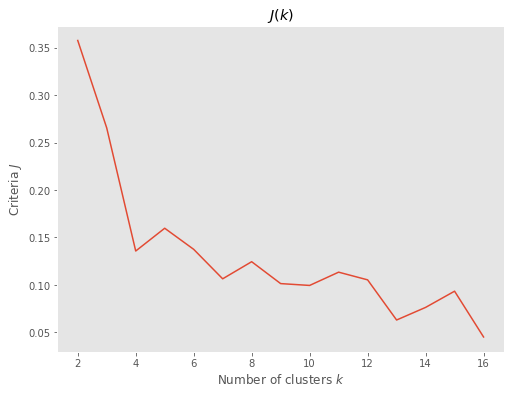

CPU times: user 8min 50s, sys: 17.6 s, total: 9min 7s
Wall time: 8min 54s


In [28]:
%time k_plot(X=X, \
    alg_name='gm', \
    quality=silhouette_score, \
    k_start=2, \
    k_end=16, \
    random_state=RAND_INIT, \
    max_iter=300 \
)

In [21]:
# db
# 0.45324793458963125
# 0.017228049478748612
%time quality(X[:10000], y[:10000])

CPU times: user 5.56 s, sys: 1.01 s, total: 6.57 s
Wall time: 5.7 s


0.017228049478748612

In [34]:
# gm
# 0.10211761067446326
# 0.13033928925836913
%time quality(X[:10000], y[:10000])

CPU times: user 5.22 s, sys: 974 ms, total: 6.19 s
Wall time: 10.1 s


0.16153533462627034

In [36]:
# kmeans normilized
# 0.19731772479319534
# 0.23474696836911094
%time quality(X[:10000], y[:10000])

CPU times: user 5.14 s, sys: 1.03 s, total: 6.17 s
Wall time: 6.64 s


0.30522358437591374

In [29]:
# tf.idf
%time quality(X, kmeans.labels_)

CPU times: user 6.64 s, sys: 767 ms, total: 7.41 s
Wall time: 7.44 s


0.12669403081173014

In [81]:
# normilized tf.idf
# from sklearn.metrics import silhouette_score
# silhouette_score(X, kmeans.labels_)
%time quality(X, kmeans.labels_)

CPU times: user 7.17 s, sys: 888 ms, total: 8.06 s
Wall time: 8.11 s


0.05269691015032827

In [42]:
with open('idf.data', 'w') as f:
    np.save(f, X)
with open('idf.labels', 'w') as f:
    np.save(f, kmeans.labels_)  

## Вывод

### Kmeans
Модификации имеют свои преимущества и недостатки.

MiniBatch дает ощутимый выигрыш по времени, однако точность несколько падает.

KMeans++ позволяет защититься от ситуации, когда два центроида оказываются случайно выбраны слишком близко друг к другу. Тем не менее, при большом числе точек время кластеризации ощутимо растет.

Таким образом, ни одну из модификаций алгоритма нельзя считать лучшей. Выбор должен определяться обстоятельствами.

### Интерпретация реальных данных

Исследовав результаты кластеризации обычным Kmeans с косинусной метрикой, я обнаружил следующие кластеры

1. Интересующиеся танцами и магазинами, которым нравится все симпатичное и сексуальное
1. Маргинальные любители наркотиков, секса и выпить, которые также больше других ценят поцелуи, волосы (!), блондинок, рок и смерть
1. Конспирлогическая секта -- рассказали о своих интересах гораздо меньше других
1. Любители церкви, Библии и Иисуса
4. Фанаты игр с мячом
5. Знают толк в шоппинге, разбираются в одежде, предпочитают бренд "Hollister" и "Abercrombie". У них также больше других встречается слово "hot" (?вероятно, перед "sales")
6. Плавцы
7. Софтболисты, которые также ценят одежду
8. Самая большая группа. Из примечательного: в этом большом коллективе в ноль игнорируют "Hollister" и "Abercrombie", а также... походы (marching). В отличие от алкоголиков не маргинальны, хотя спектр интересов очень схож


In [32]:
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import gc
from sklearn.utils import shuffle

def quality(x, y):
    x, y = shuffle(x, y, random_state=RAND_INIT)    
    x = x[:10000]
    y = y[:10000]
    gc.collect()
    
    n, d = x.shape
    k = y.max() + 1
    classmasks = np.empty((k, n), dtype=bool)
    means = np.empty(n, k)
    
    dists = squareform(pdist(x))
    gc.collect()

        
    classmasks = np.array(xrange(k))[:, None] == y
    gc.collect()

    class_dists = np.array([dists[:,classmasks[i]].mean(axis=1) for i in xrange(k)])
    dists = None
    gc.collect()
    
    a_x = (class_dists * classmasks).max(axis=0)
    gc.collect()
    
    max_val = class_dists.max()
    gc.collect()
    b_x = (class_dists + (classmasks * max_val)).min(axis=0)
    
    class_dists = None
    gc.collect()
    
    sil_x = (b_x - a_x) / np.amax((a_x, b_x), axis=0)
    a_x = None
    b_x = None
    gc.collect()
    
    return sil_x.mean()